In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from IPython.display import clear_output

from selenium import webdriver
import time
import datetime
import random

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Function
from numba import jit

import soft_dtw
import path_soft_dtw 

## check CUDA
print('Is CUDA available ?', torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


Is CUDA available ? True


In [2]:
def set_seeds(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def RS_vol(data):
    first_element = np.log(data['最高價(元)'].astype(float))-np.log(data['開盤價(元)'].astype(float))
    second_element = np.log(data['最高價(元)'].astype(float))-np.log(data['收盤價(元)'].astype(float))
    third_element = np.log(data['最低價(元)'].astype(float))-np.log(data['開盤價(元)'].astype(float))
    fouth_element = np.log(data['最低價(元)'].astype(float))-np.log(data['收盤價(元)'].astype(float))
    volatility_rs = first_element*second_element+third_element*fouth_element
    return volatility_rs

In [4]:
def dilate_loss(outputs, targets, alpha, gamma, device):
    # outputs, targets: shape (batch_size, N_output, 1)
    batch_size, N_output = outputs.shape[0:2]
    loss_shape = 0
    softdtw_batch = soft_dtw.SoftDTWBatch.apply
    D = torch.zeros((batch_size, N_output, N_output)).to(device)
    for k in range(batch_size):
        Dk = soft_dtw.pairwise_distances(targets[k,:,:].view(-1,1),outputs[k,:,:].view(-1,1))
        D[k:k+1,:,:] = Dk     
    loss_shape = softdtw_batch(D,gamma)

    path_dtw = path_soft_dtw.PathDTWBatch.apply
    path = path_dtw(D,gamma)           
    Omega =  soft_dtw.pairwise_distances(torch.range(1,N_output).view(N_output,1)).to(device)
    loss_temporal =  torch.sum( path*Omega ) / (N_output*N_output) 
    loss = alpha*loss_shape+ (1-alpha)*loss_temporal
    return loss, loss_shape, loss_temporal

In [91]:
class HuberL1Loss(nn.Module):
    def __init__(self, delta, alpha):
        super(HuberL1Loss, self).__init__()
        self.huber_loss = nn.HuberLoss(delta = delta)
        self.l1_loss = nn.L1Loss()
        self.alpha = alpha

    def forward(self, y_pred, y_target):
        prediction_loss = self.huber_loss(y_pred, y_target)
        regularization_loss = self.l1_loss(y_pred, y_target)
        
        total_loss = prediction_loss + self.alpha * regularization_loss
        return total_loss

## 選擇權資料爬蟲

In [ ]:
url = "https://www.taifex.com.tw/cht/3/pcRatio"
year = [i for i in range(2010, 2025, 1)]
month = [i for i in range(1, 13, 1)]
date = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

driver = webdriver.Chrome()
driver.get(url)
begin = True

for y in year:
    for i in range(len(month)):
        start = f"{y}/{month[i]}/01"
        if y%4 == 0 and month[i] == 2:
            end = f"{y}/{month[i]}/{date[i]+1}"
        else:
            end = f"{y}/{month[i]}/{date[i]}"
        
        print(start, end)
        if pd.to_datetime(start) > datetime.datetime.today():
            break
            
        element = driver.find_element_by_css_selector("#queryStartDate")
        element.clear()
        element.send_keys(start)
        element = driver.find_element_by_css_selector("#queryEndDate")
        element.clear()
        element.send_keys(end)
        button = driver.find_element_by_css_selector("#button4")
        button.click()
        table = pd.read_html(driver.page_source)[2][::-1]
        
        if begin == True:
            TABLE = table
            begin = False
        else:
            TABLE = pd.concat([TABLE, table])
        time.sleep(5)

In [ ]:
TABLE.to_excel("option_data.xlsx")

## Data Preprocessing

In [5]:
option_data = pd.read_excel("option_data.xlsx").iloc[:, 1:]
option_data['日期'] = pd.to_datetime(option_data['日期'])
option_data = option_data.set_index('日期')
option_data

,賣權成交量,買權成交量,買賣權成交量比率%,賣權未平倉量,買權未平倉量,買賣權未平倉量比率%
日期,,,,,,
2010-01-04,118565,139994,84.69,414317,316753,130.80
2010-01-05,142914,186417,76.66,437417,343792,127.23
2010-01-06,193433,226856,85.27,472948,341507,138.49
2010-01-07,165596,213070,77.72,507353,368773,137.58
2010-01-08,156419,156613,99.88,533142,387243,137.68
...,...,...,...,...,...,...
2024-02-29,500698,472765,105.91,169020,132997,127.09
2024-03-01,269706,245507,109.86,226663,177396,127.77
2024-03-04,568828,529900,107.35,309961,212527,145.85


In [6]:
export_data = pd.read_excel('export_data.xlsx')
export_data[' '] = export_data[' '].replace(' ', np.nan).ffill()
export_data[' '] = export_data[' '].str.replace('年', '')
export_data[' .1'] = export_data[' .1'].str.replace('月', '')
export_data = export_data.astype(float)
export_data['年月'] = pd.to_datetime((export_data[' ']+1911).astype(int).astype(str) + "/" + (export_data[' .1']).astype(int).astype(str))
export_data

C:\Users\User\AppData\Local\Temp\ipykernel_17356\3173700196.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  export_data['年月'] = pd.to_datetime((export_data[' ']+1911).astype(int).astype(str) + "/" + (export_data[' .1']).astype(int).astype(str))


,,.1,美國_電機產品,美國_資訊與通信產品,日本_電機產品,日本_資訊與通信產品,中國_電機產品,中國_資訊與通信產品,東協_電機產品,東協_資訊與通信產品,歐洲_電機產品,歐洲_資訊與通信產品,其他_電機產品,其他_資訊與通信產品,年月
0,98.0,11.0,218.211500,2391.510100,59.260900,1561.095500,786.918800,452.056900,66.859900,851.207800,232.189800,2607.679200,238.152400,714.674100,2009-11-01
1,98.0,12.0,215.643700,2393.267100,46.455500,1561.905600,832.746600,530.376600,68.294900,741.717300,221.210800,2335.744800,245.775400,638.555300,2009-12-01
2,99.0,1.0,197.347700,2044.555000,48.444700,1472.702500,844.488500,519.680300,62.125000,793.269000,208.613100,2109.829800,209.457400,618.597300,2010-01-01
3,99.0,2.0,186.771900,1689.135400,53.356700,1450.046000,758.666600,421.450300,65.429700,701.717200,180.437400,2115.418600,359.518800,611.793400,2010-02-01
4,99.0,3.0,222.999000,1920.937900,60.132900,1584.546500,969.873000,612.702500,73.880700,880.161800,228.440900,2472.460400,469.743500,721.633200,2010-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,112.0,9.0,506.425635,6039.589587,72.385833,584.811952,603.770918,1202.877312,119.713185,3320.737508,141.200670,3979.409547,152.180132,1320.258271,2023-09-01
167,112.0,10.0,515.371967,5581.052965,95.918119,583.955296,529.837128,1182.006175,127.223683,4980.080713,141.260918,4076.759325,156.888246,1092.440354,2023-10-01
168,112.0,11.0,496.883553,5470.026756,75.801979,586.624463,560.855468,1057.692775,137.623336,3571.893039,144.196627,4309.773407,146.903694,1200.713493,2023-11-01
169,112.0,12.0,490.169662,4408.734485,79.131202,502.038741,518.136229,890.816442,126.279595,2149.789848,157.679877,3181.025971,145.007608,1141.068603,2023-12-01


In [7]:
export = pd.DataFrame()
export['年月'] = export_data['年月']
export['American'] = export_data['美國_電機產品'] + export_data['美國_資訊與通信產品']
export['American ratio'] = export['American'] / export_data.iloc[:, 2:-1].sum(axis = 1)
export

,年月,American,American ratio
0,2009-11-01,2609.721600,0.256362
1,2009-12-01,2608.910800,0.265357
2,2010-01-01,2241.902700,0.245577
3,2010-02-01,1875.907300,0.218288
4,2010-03-01,2143.936900,0.209830
...,...,...,...
166,2023-09-01,6546.015222,0.362794
167,2023-10-01,6096.424932,0.319808
168,2023-11-01,5966.910309,0.335994
169,2023-12-01,4898.904147,0.355254


In [8]:
stock_data = pd.read_excel('0050_data.xlsx')
stock_data['年月日'] = pd.to_datetime(stock_data['年月日'])
stock_data = stock_data.set_index('年月日')
stock_data

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股)
年月日,,,,,
2010-01-04,35.3596,35.4849,35.1090,35.3909,20083
2010-01-05,35.5788,35.6415,35.1717,35.3909,16453
2010-01-06,35.3909,36.1739,35.3909,36.0486,19012
2010-01-07,36.0799,36.4245,35.8920,35.9547,14110
2010-01-08,35.8920,36.1739,35.7354,36.1739,11342
...,...,...,...,...,...
2024-02-29,143.0000,143.9500,142.7000,143.3000,7372
2024-03-01,143.5500,143.9500,142.8000,142.8000,9019
2024-03-04,145.0000,147.2000,144.8500,146.9500,25733


In [9]:
# Features
feature = pd.DataFrame()

In [10]:
company_data = pd.read_excel("companies_data.xlsx")

In [11]:
companies = ['台積電', '聯發科', '鴻海']#, '廣達', '台達電', '聯電', '中信金', '富邦金', '中華電', '兆豐金', '國泰金', '玉山金', '統一', '聯詠', '緯創', '華碩', '元大金']
for comp in companies:
    company = company_data.filter(like = comp)
    company.columns = company.iloc[0]
    # 調整 columns name，所以從第一 row 開始取
    company = company.iloc[1:]
    company = company.set_index(stock_data.index)
    company['收盤價(元)'] = company['收盤價(元)'].astype(float)
    
    feature[comp + '_return'] = np.log(company['收盤價(元)']/company['收盤價(元)'].shift(1)).iloc[1:]
    company = company.iloc[1:]
    feature[comp + '_rsvol'] = RS_vol(company)
    feature[comp + '_法人成交比重'] = company['法人成交比重']
    feature[comp + '_信用交易比重'] = company['信用交易比重']
    feature[comp + '_券資比'] = company['券資比']
    

# 這些資料是當天交易結束會得到的 features，例如 2010/01/05 交易結束會得到的。若要拿來當 features 則需要 shift(1)，預測 2010/01/06 的 returns
display(feature)

,台積電_return,台積電_rsvol,台積電_法人成交比重,台積電_信用交易比重,台積電_券資比,聯發科_return,聯發科_rsvol,聯發科_法人成交比重,聯發科_信用交易比重,聯發科_券資比,鴻海_return,鴻海_rsvol,鴻海_法人成交比重,鴻海_信用交易比重,鴻海_券資比
年月日,,,,,,,,,,,,,,,
2010-01-05,-0.006184,0.000174,51.23,0.72,22.9,0.001762,0.000325,47.81,6.49,49.86,0.006580,0.000338,48.15,4.28,37.19
2010-01-06,0.006184,0.000233,53.62,1.75,22.86,0.012249,0.000243,62.37,5.24,48.93,-0.006580,0.000032,64.18,1.62,34.39
2010-01-07,-0.010846,0.000019,63.03,1.97,22.94,-0.024649,0.000047,56.96,4.99,48.81,-0.009949,0.000310,53.09,1.3,34.23
2010-01-08,-0.003120,0.000059,62.4,1.55,22.53,-0.019803,0.000248,45.29,5.41,42.17,0.003327,0.000497,51.74,2.89,33.16
2010-01-11,0.007781,0.000209,51.15,2.71,24.06,0.014441,0.000188,51.28,7.92,45.59,-0.013377,0.000135,54.1,1.92,30.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,-0.011528,0.000129,79.46,0.02,2.62,0.022174,0.000236,65.66,0.04,3.9,-0.004843,0.000023,56.16,0.01,0.49
2024-03-01,-0.001450,0.000019,55.44,0.02,2.59,-0.031183,0.000563,54.48,0.05,3.64,-0.009756,0.000071,51.92,0.02,0.51
2024-03-04,0.050930,0.000082,47.87,0.03,4,0.039917,0.000513,54.05,0.05,4.25,0.043172,0.000201,36.04,0.04,0.61


In [12]:
interest_data = pd.read_excel('interestrate_data.xlsx')
interest_data['observation_date'] = pd.to_datetime(interest_data['observation_date'])
interest_data.set_index('observation_date', drop = True, inplace = True)
interest_data

,REAINTRATREARAT10Y
observation_date,
2009-12-01,0.848041
2010-01-01,1.297925
2010-02-01,1.124515
2010-03-01,0.998732
2010-04-01,1.309105
...,...
2023-10-01,2.082461
2023-11-01,2.094329
2023-12-01,1.680899


In [13]:
interest_data['observation_date'] = pd.to_datetime(interest_data.index)
stock_data['年月日'] = pd.to_datetime(stock_data.index)

stock_data['year_month'] = (stock_data['年月日'] - pd.DateOffset(months=1)).dt.to_period('M')
interest_data['year_month'] = interest_data['observation_date'].dt.to_period('M')

# Merge the two datasets
merged_data_final = pd.merge(stock_data, interest_data, on='year_month', how='left')

# Clean up by dropping the additional 'year_month' column used for merging
merged_data_final = merged_data_final.drop(columns=['year_month'])
merged_data_final.set_index('年月日', inplace = True)
merged_data_final.drop(columns = ['observation_date'], inplace = True)

merged_data_final

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),REAINTRATREARAT10Y
年月日,,,,,,
2010-01-04,35.3596,35.4849,35.1090,35.3909,20083,0.848041
2010-01-05,35.5788,35.6415,35.1717,35.3909,16453,0.848041
2010-01-06,35.3909,36.1739,35.3909,36.0486,19012,0.848041
2010-01-07,36.0799,36.4245,35.8920,35.9547,14110,0.848041
2010-01-08,35.8920,36.1739,35.7354,36.1739,11342,0.848041
...,...,...,...,...,...,...
2024-02-29,143.0000,143.9500,142.7000,143.3000,7372,1.680871
2024-03-01,143.5500,143.9500,142.8000,142.8000,9019,1.618134
2024-03-04,145.0000,147.2000,144.8500,146.9500,25733,1.618134


In [14]:
stock_data['export_month_data'] = (stock_data['年月日'] - pd.DateOffset(months = 2)).dt.to_period('M')
export['export_month_data'] = export['年月'].dt.to_period('M')
export = pd.merge(stock_data, export, on='export_month_data', how='left')
export.set_index(stock_data.index, inplace = True)
merged_data_final['American export'] = export['American'].astype(float)
merged_data_final['American export ratio'] = export['American ratio'].astype(float)
merged_data_final

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),REAINTRATREARAT10Y,American export,American export ratio
年月日,,,,,,,,
2010-01-04,35.3596,35.4849,35.1090,35.3909,20083,0.848041,2609.721600,0.256362
2010-01-05,35.5788,35.6415,35.1717,35.3909,16453,0.848041,2609.721600,0.256362
2010-01-06,35.3909,36.1739,35.3909,36.0486,19012,0.848041,2609.721600,0.256362
2010-01-07,36.0799,36.4245,35.8920,35.9547,14110,0.848041,2609.721600,0.256362
2010-01-08,35.8920,36.1739,35.7354,36.1739,11342,0.848041,2609.721600,0.256362
...,...,...,...,...,...,...,...,...
2024-02-29,143.0000,143.9500,142.7000,143.3000,7372,1.680871,4898.904147,0.355254
2024-03-01,143.5500,143.9500,142.8000,142.8000,9019,1.618134,5162.132156,0.335166
2024-03-04,145.0000,147.2000,144.8500,146.9500,25733,1.618134,5162.132156,0.335166


In [15]:
VIX = pd.read_excel("VIX_data.xlsx")
VIX.columns = ['年月日', 'VIXCLS']
stock_data_v = pd.read_excel("0050_data.xlsx")
stock_data_v
VIX = pd.merge(stock_data_v, VIX, on = '年月日', how = 'left')[['年月日', 'VIXCLS']]
VIX['年月日'] = pd.to_datetime(VIX['年月日'])
VIX.set_index('年月日', inplace = True)
VIX = VIX.fillna(method = 'ffill')

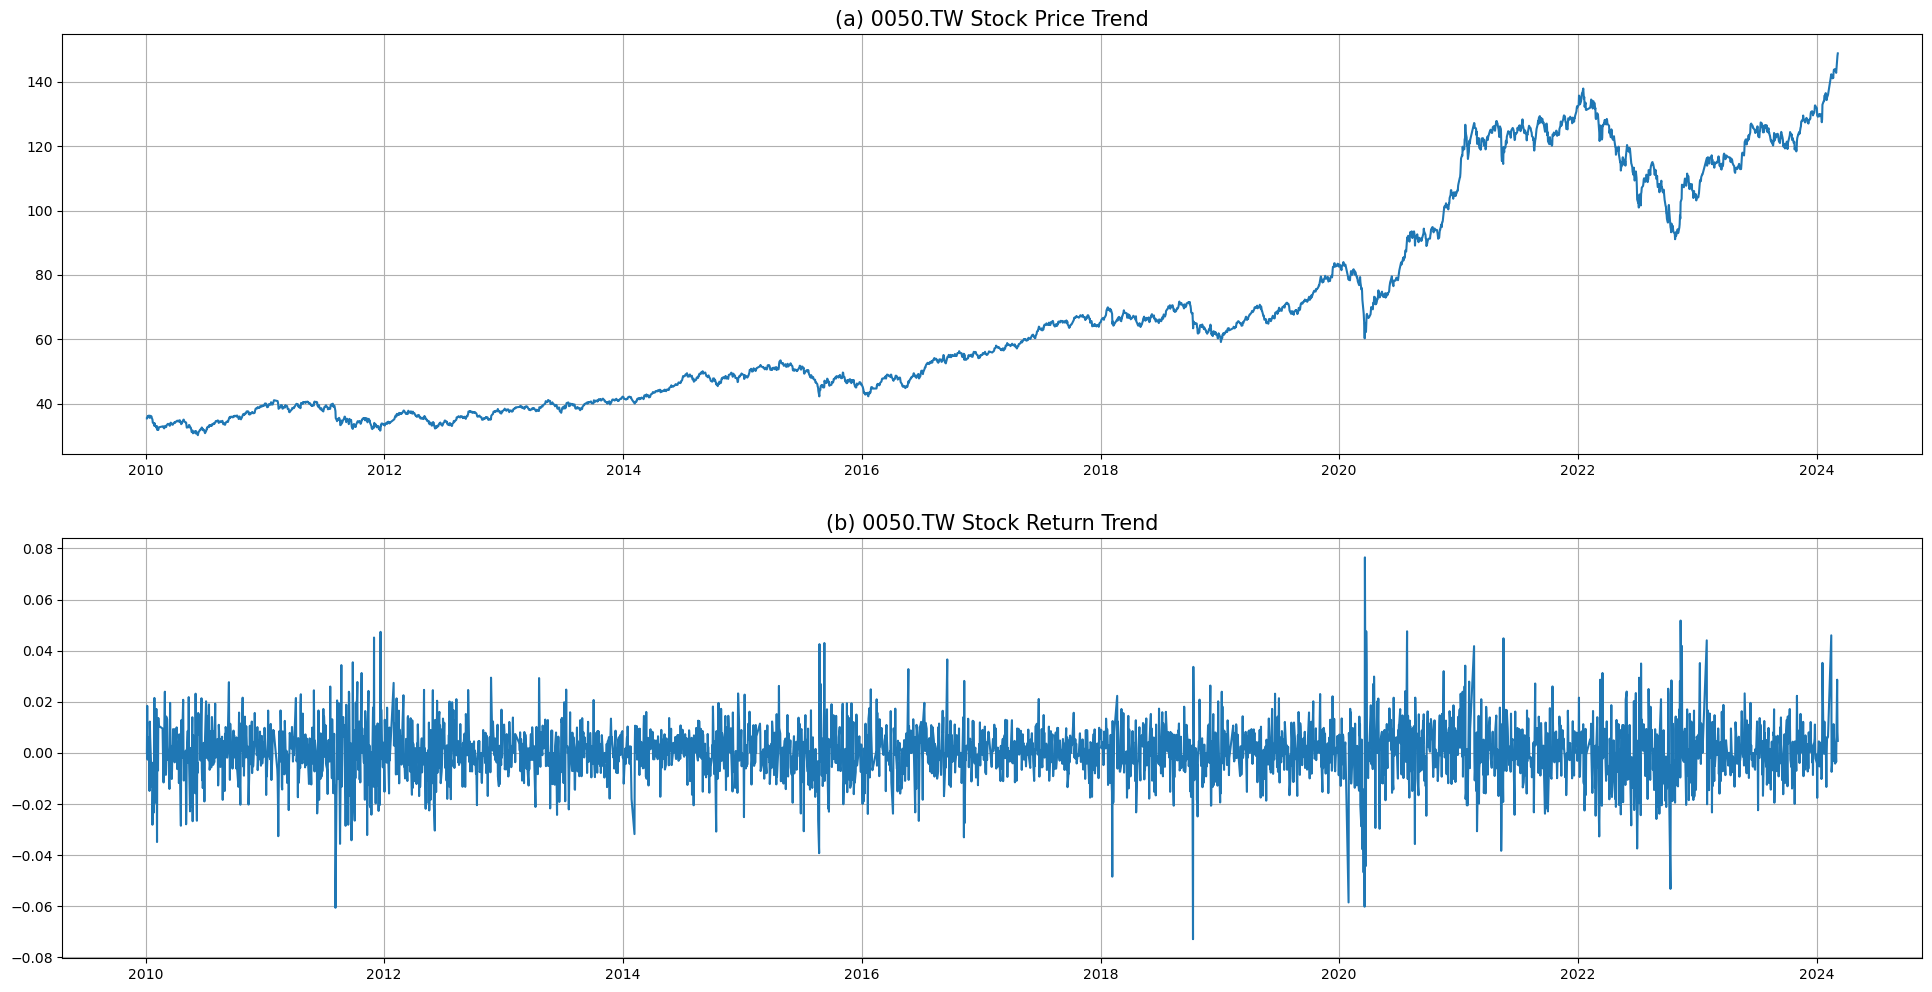

In [15]:
plt.figure(figsize = (24, 12))
plt.subplot(211)
plt.grid(True)
plt.title("(a) 0050.TW Stock Price Trend", fontsize = 15)
plt.plot(merged_data_final['收盤價(元)'])
plt.subplot(212)
plt.grid(True)
plt.title("(b) 0050.TW Stock Return Trend", fontsize = 15)
plt.plot(np.log(merged_data_final['收盤價(元)']/merged_data_final['收盤價(元)'].shift(1)).iloc[1:])

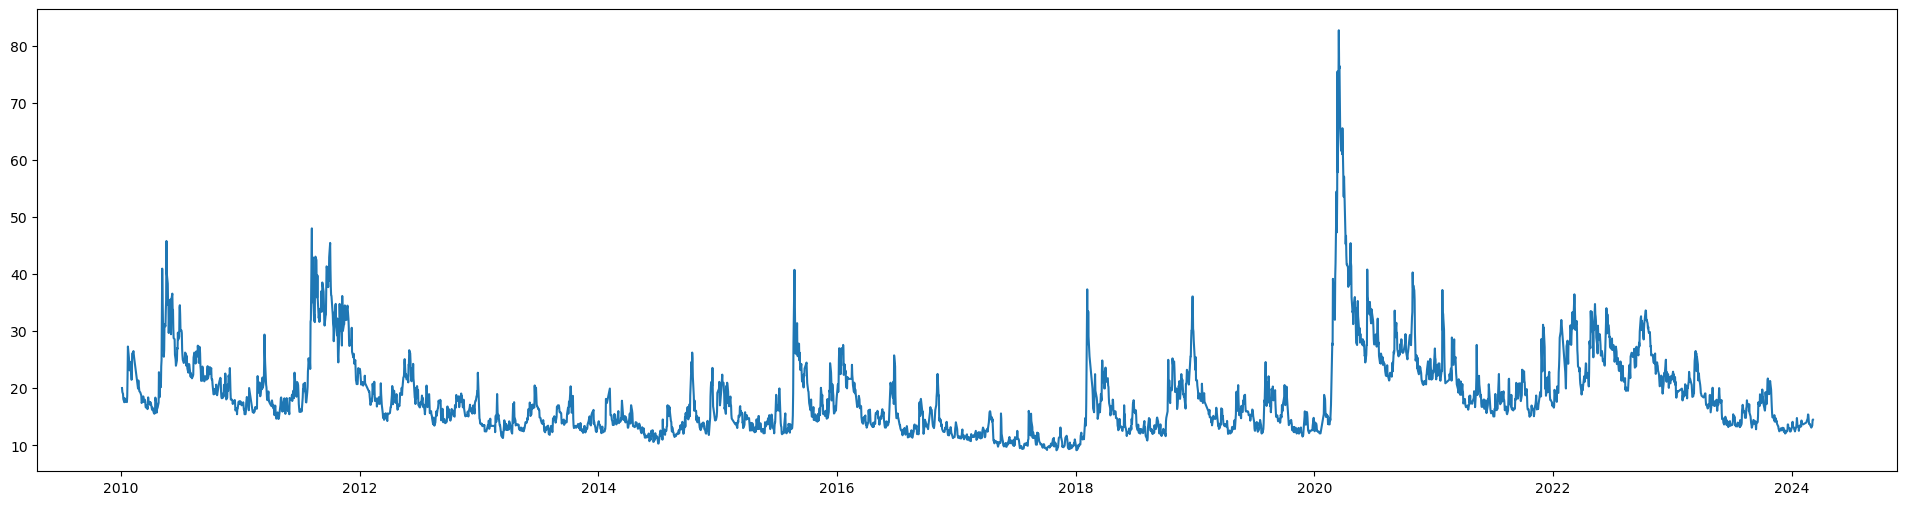

In [25]:
plt.figure(figsize = (24, 6))
plt.plot(VIX['VIXCLS'])

<Axes: >

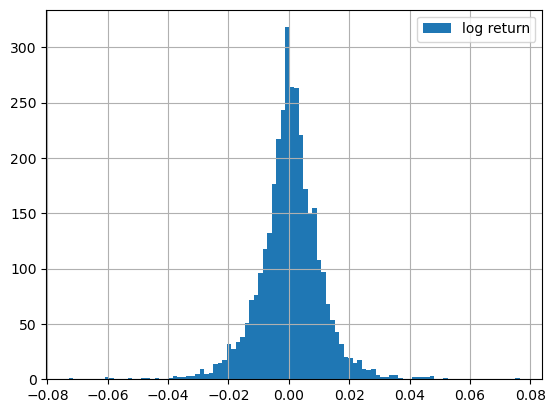

In [231]:
logreturns = np.log(merged_data_final['收盤價(元)']/merged_data_final['收盤價(元)'].shift(1)).iloc[1:]
logreturns.name = 'log return'
logreturns.hist(bins = 100, legend = True)

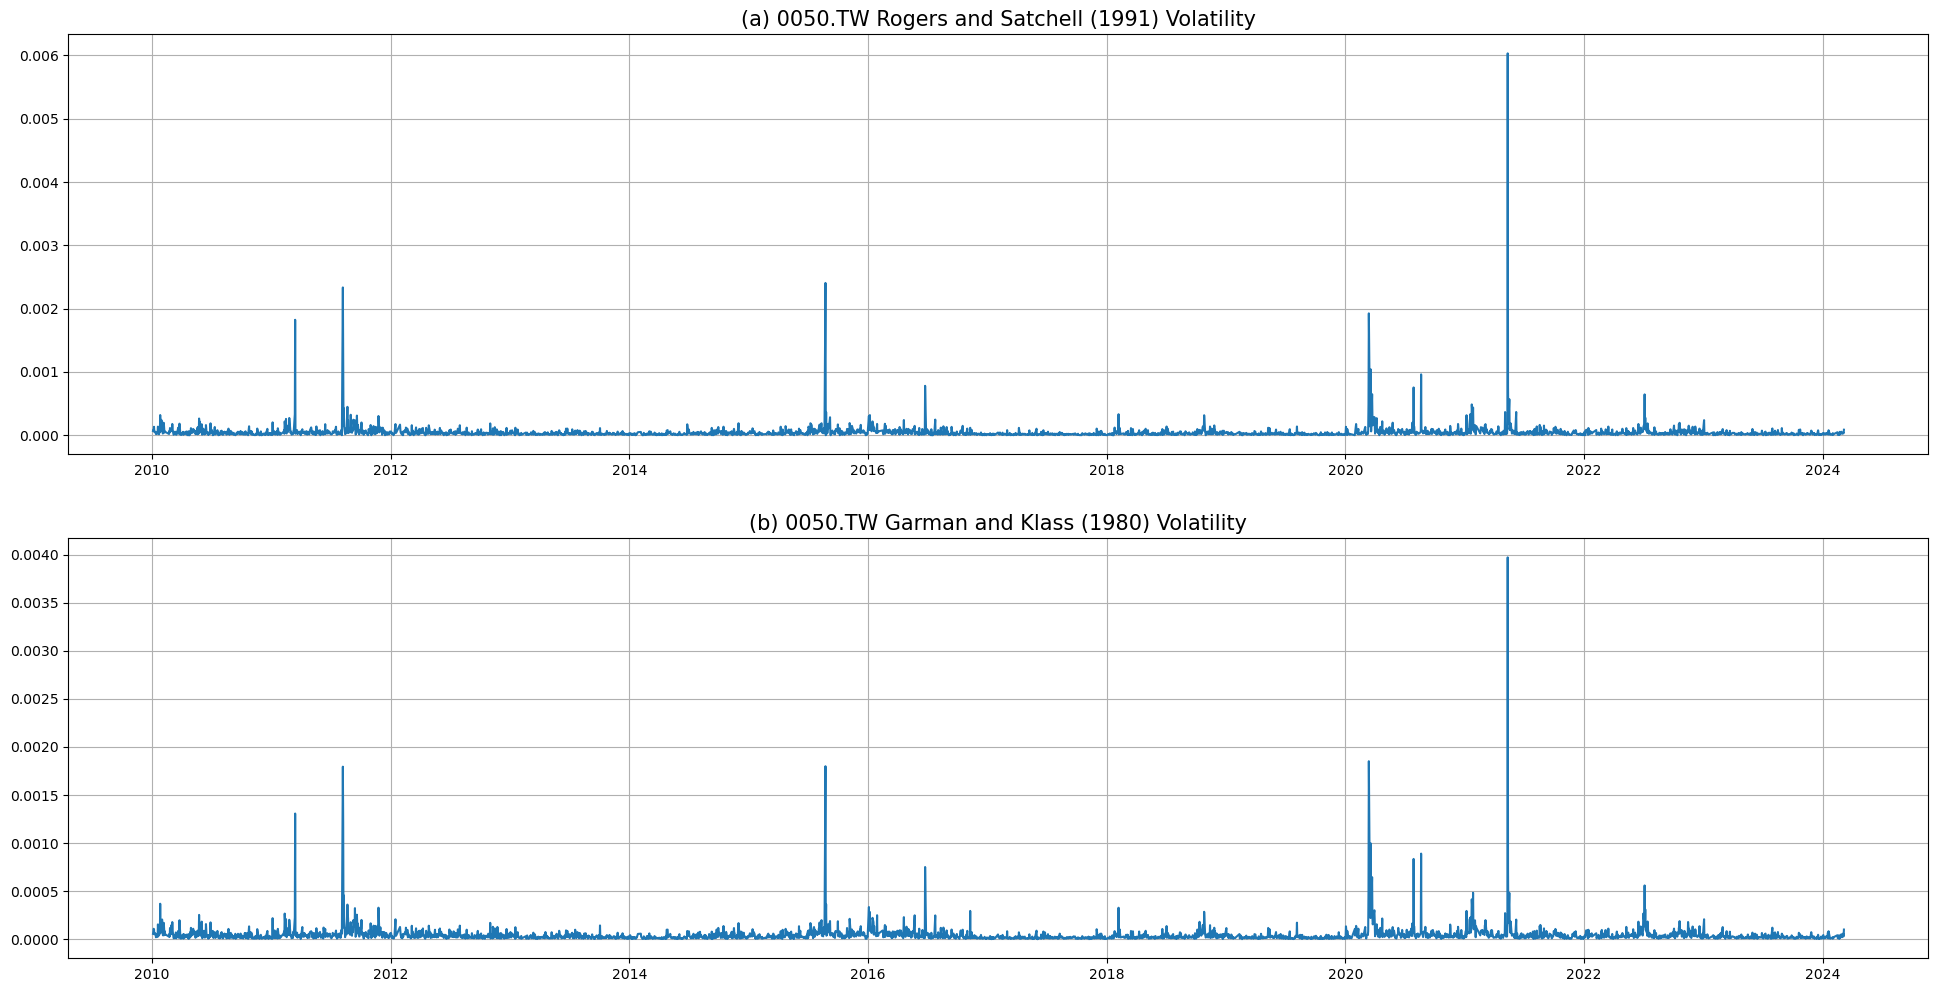

In [868]:
first_element = np.log(merged_data_final['最高價(元)'])-np.log(merged_data_final['開盤價(元)'])
second_element = np.log(merged_data_final['最高價(元)'])-np.log(merged_data_final['收盤價(元)'])
third_element = np.log(merged_data_final['最低價(元)'])-np.log(merged_data_final['開盤價(元)'])
fouth_element = np.log(merged_data_final['最低價(元)'])-np.log(merged_data_final['收盤價(元)'])
volatility_rs = first_element*second_element+third_element*fouth_element

first_element = np.log(merged_data_final['最高價(元)'])-np.log(merged_data_final['最低價(元)'])
second_element = np.log(merged_data_final['收盤價(元)'])-np.log(merged_data_final['開盤價(元)'])
volatility_gk = 0.5*first_element*first_element-(2*np.log(2)-1)*second_element*second_element

plt.figure(figsize = (24, 12))
plt.subplot(211)
plt.title("(a) 0050.TW Rogers and Satchell (1991) Volatility", fontsize = 15)
plt.grid(True)
plt.plot(volatility_rs)
plt.subplot(212)
plt.title("(b) 0050.TW Garman and Klass (1980) Volatility", fontsize = 15)
plt.grid(True)
plt.plot(volatility_gk)

In [86]:
R_data = pd.DataFrame()
R_data['Price'] = stock_data['收盤價(元)']
R_data['LogReturn'] = np.log(stock_data['收盤價(元)']/stock_data['收盤價(元)'].shift(1))
R_data.iloc[1:].to_csv("R_data.csv")
volatility_rs.to_csv('R_data_vol.csv')

# Models
## 1. Naive LSTM Price Prediction Model, using Previous Prices

In [248]:
lstm_price = stock_data.copy(deep = True)
previous_prices_data = 6
for i in range(previous_prices_data):
    lstm_price[f"Lag {i}"] = lstm_price['收盤價(元)'].shift(i)

lstm_price = lstm_price.iloc[5:, -6:]
train_size = int(0.8 * lstm_price.shape[0])
train_lstm_price = lstm_price.iloc[ :train_size]
test_lstm_price = lstm_price.iloc[train_size: ]
train_lstm_price

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
年月日,,,,,,
2010-01-11,36.2679,36.1739,35.9547,36.0486,35.3909,35.3909
2010-01-12,36.0799,36.2679,36.1739,35.9547,36.0486,35.3909
2010-01-13,35.5475,36.0799,36.2679,36.1739,35.9547,36.0486
2010-01-14,35.9860,35.5475,36.0799,36.2679,36.1739,35.9547
2010-01-15,36.2052,35.9860,35.5475,36.0799,36.2679,36.1739
...,...,...,...,...,...,...
2021-04-22,124.8060,124.8965,126.0278,126.2541,126.0278,125.8468
2021-04-23,125.9373,124.8060,124.8965,126.0278,126.2541,126.0278
2021-04-26,127.7926,125.9373,124.8060,124.8965,126.0278,126.2541


In [249]:
train_lstm_x = train_lstm_price.iloc[:, range(train_lstm_price.shape[1]-1 ,0, -1)].to_numpy()
train_lstm_y = train_lstm_price.iloc[:, 0].to_numpy()

test_lstm_x = test_lstm_price.iloc[:, range(test_lstm_price.shape[1]-1 ,0, -1)].to_numpy()
test_lstm_y = test_lstm_price.iloc[:, 0].to_numpy()

standard = StandardScaler()
standard.fit(train_lstm_x)
train_lstm_x = standard.transform(train_lstm_x)
test_lstm_x = standard.transform(test_lstm_x)

train_lstm_x = torch.tensor(train_lstm_x, dtype = torch.float32).to(device)
train_lstm_y = torch.tensor(train_lstm_y, dtype = torch.float32).to(device)
test_lstm_x = torch.tensor(test_lstm_x, dtype = torch.float32).to(device)
test_lstm_y = torch.tensor(test_lstm_y, dtype = torch.float32).to(device)

In [250]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, self.num_layers, batch_first = True, dropout = 0.3 if self.num_layers > 1 else 0)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
    
    def forward(self, x):
        # x.shape = batch size x sequence_dim x input_dim = batch size x 5 x 1
        
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        #out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [251]:
def training_lstm(num_epoch, model, train_data_loader, device, loss_function, optimizer, input_dim, output_dim, dilate = False):
    
    loss_list = []
    total_steps = len(train_data_loader)
    for epoch in range(num_epoch):
        clear_output(wait = True)
        epoch_loss = 0
        for _, (x, y) in enumerate(train_data_loader):
            B, S = x.shape
            x = x.reshape(B, S, input_dim)
            y = y.reshape(B, output_dim)
            model.train()
            y_hat = model(x)
            
            if dilate:
                alpha = 0.5
                gamma = 0.001
                loss_function_loss = loss_function(y_hat, y)
                epoch_loss += loss_function_loss
                
                y = y.unsqueeze(2)
                y_hat = y_hat.unsqueeze(2)
                loss, loss_shape, loss_temporal = dilate_loss(y, y_hat, alpha, gamma, device)
            else:
                loss = loss_function(y_hat, y)
                epoch_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch + 1} / {num_epoch}], Loss: {epoch_loss / total_steps}')
        loss_list.append(epoch_loss.cpu().detach() / total_steps)
    
    return loss_list

In [252]:
def testing_lstm(model, test_data_loader, loss_function, input_dim, output_dim):
    model.eval()
    
    total_loss = [0] * output_dim
    y_pred = [[] for i in range(output_dim)]
    for _, (x, y) in enumerate(test_data_loader):
        with torch.no_grad():
            B, S = x.shape
            x = x.reshape(B, S, input_dim)
            y_hat = model(x).squeeze()
            
            if output_dim != 1:
                for i in range(output_dim):
                    y_hat_i = y_hat[:, i]
                    y_pred[i].extend(y_hat_i.cpu().detach().numpy().tolist())
            else:
                y_hat = y_hat.cpu().detach().numpy().reshape(-1).tolist()
                y_pred[0].extend(y_hat)
    
    return y_pred

In [253]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCH = 300

input_dim = 1
hidden_dim = 50
output_dim = 1
num_layers = 10

train_loader = DataLoader(dataset = TensorDataset(train_lstm_x, train_lstm_y), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(test_lstm_x, test_lstm_y), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer= torch.optim.Adam(lstm_model.parameters(), lr = LEARNING_RATE)
loss_function = nn.MSELoss()

loss_list = training_lstm(NUM_EPOCH, lstm_model, train_loader, device, loss_function, optimizer, input_dim, output_dim)
y_hat = testing_lstm(lstm_model, test_loader, loss_function, input_dim, output_dim)

R_squared = r2_score(test_lstm_y.cpu().detach().numpy().tolist(), y_hat[0])
print(f"LSTM testing R squared: {round(R_squared, 4)}")

Epoch [300 / 300], Loss: 2.246328830718994
LSTM testing R squared: 0.6211


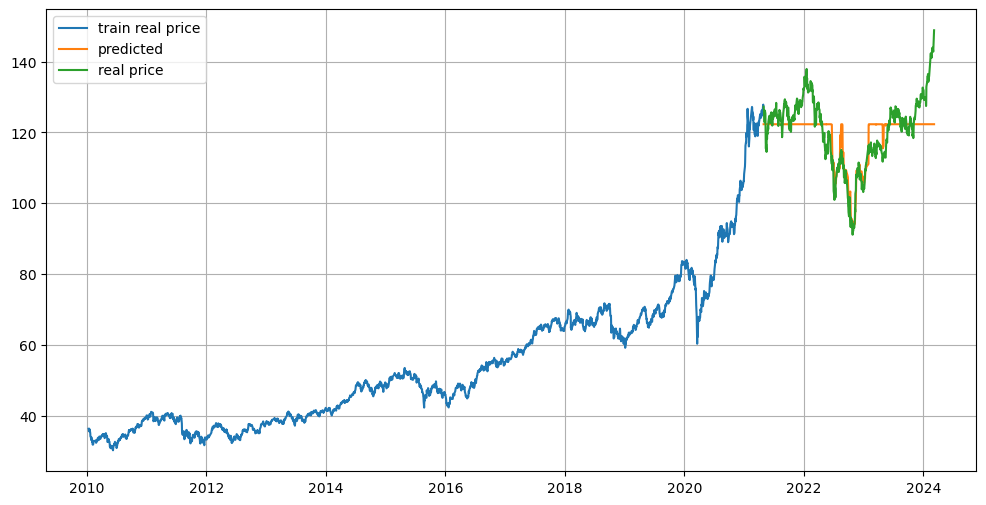

In [254]:
plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_lstm_price.index, train_lstm_y.cpu().detach().numpy(), label = 'train real price')
plt.plot(test_lstm_price.index, y_hat[0], label = 'predicted')
plt.plot(test_lstm_price.index, test_lstm_y.cpu().detach().numpy(), label = 'real price')
plt.legend()

## 2. LSTM Price Prediction Model for the Next Five Days

In [196]:
seed_value = 18

lstm_price = stock_data.copy(deep = True)
previous_prices_data = 5
for i in range(2 * previous_prices_data):
    lstm_price[f"Lag {2 * previous_prices_data - i}"] = lstm_price['收盤價(元)'].shift(2 * previous_prices_data - i)
for i in range(previous_prices_data):
    lstm_price[f"Next {i}"] = lstm_price['收盤價(元)'].shift(-i)

lstm_price = lstm_price.iloc[2* previous_prices_data:, -3* previous_prices_data:]
train_size = int(0.9 * lstm_price.shape[0])

train_lstm_price = lstm_price.iloc[ :train_size]
test_lstm_price = lstm_price.iloc[train_size: ]
train_lstm_price

,Lag 10,Lag 9,Lag 8,Lag 7,Lag 6,Lag 5,Lag 4,Lag 3,Lag 2,Lag 1,Next 0,Next 1,Next 2,Next 3,Next 4
年月日,,,,,,,,,,,,,,,
2010-01-18,35.3909,35.3909,36.0486,35.9547,36.1739,36.2679,36.0799,35.5475,35.9860,36.2052,36.0173,35.5475,35.3283,35.0464,34.0755
2010-01-19,35.3909,36.0486,35.9547,36.1739,36.2679,36.0799,35.5475,35.9860,36.2052,36.0173,35.5475,35.3283,35.0464,34.0755,33.9502
2010-01-20,36.0486,35.9547,36.1739,36.2679,36.0799,35.5475,35.9860,36.2052,36.0173,35.5475,35.3283,35.0464,34.0755,33.9502,33.1672
2010-01-21,35.9547,36.1739,36.2679,36.0799,35.5475,35.9860,36.2052,36.0173,35.5475,35.3283,35.0464,34.0755,33.9502,33.1672,33.1359
2010-01-22,36.1739,36.2679,36.0799,35.5475,35.9860,36.2052,36.0173,35.5475,35.3283,35.0464,34.0755,33.9502,33.1672,33.1359,33.8563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-19,107.2872,107.5227,108.2291,105.6859,106.4394,108.7001,109.2653,107.0517,107.2401,106.0156,105.5446,106.4865,105.5917,104.3201,103.3310
2022-09-20,107.5227,108.2291,105.6859,106.4394,108.7001,109.2653,107.0517,107.2401,106.0156,105.5446,106.4865,105.5917,104.3201,103.3310,101.4001
2022-09-21,108.2291,105.6859,106.4394,108.7001,109.2653,107.0517,107.2401,106.0156,105.5446,106.4865,105.5917,104.3201,103.3310,101.4001,101.2588


In [197]:
train_lstm_x = train_lstm_price.iloc[:, :previous_prices_data * 2].to_numpy()
train_lstm_y = train_lstm_price.iloc[:, previous_prices_data * 2:].to_numpy()

test_lstm_x = test_lstm_price.iloc[: -(previous_prices_data + 1), :previous_prices_data * 2].to_numpy()
test_lstm_y = test_lstm_price.iloc[: -(previous_prices_data + 1), previous_prices_data * 2:].to_numpy()

standard = StandardScaler()
standard.fit(train_lstm_x)
train_lstm_x = standard.transform(train_lstm_x)
test_lstm_x = standard.transform(test_lstm_x)

train_lstm_x = torch.tensor(train_lstm_x, dtype = torch.float32).to(device)
train_lstm_y = torch.tensor(train_lstm_y, dtype = torch.float32).to(device)
test_lstm_x = torch.tensor(test_lstm_x, dtype = torch.float32).to(device)
test_lstm_y = torch.tensor(test_lstm_y, dtype = torch.float32).to(device)

In [206]:
# Baseline
y_test = test_lstm_price.iloc[: -(previous_prices_data + 1), previous_prices_data * 2:]
x_test = test_lstm_price.iloc[: -(previous_prices_data + 1), :previous_prices_data * 2]
for i in range(output_dim):
    print(f"Baseline MSE for the next T + {i+1} days: {mean_squared_error(y_test.iloc[:, i], x_test.iloc[:, -1])}")

Baseline MSE for the next T + 1 days: 1.585972490674488
Baseline MSE for the next T + 2 days: 3.191302582609971
Baseline MSE for the next T + 3 days: 5.128441811524929
Baseline MSE for the next T + 4 days: 6.769532606011732
Baseline MSE for the next T + 5 days: 8.305702753313785


In [202]:
# Normal Loss

BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCH = 300

input_dim = 1
hidden_dim = 50
output_dim = 5
num_layers = 10
set_seeds(seed_value)


train_loader = DataLoader(dataset = TensorDataset(train_lstm_x, train_lstm_y), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(test_lstm_x, test_lstm_y), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer= torch.optim.Adam(lstm_model.parameters(), lr = LEARNING_RATE)
loss_function = nn.MSELoss()

loss_list = training_lstm(NUM_EPOCH, lstm_model, train_loader, device, loss_function, optimizer, input_dim, output_dim, False)

y_hat = testing_lstm(lstm_model, test_loader, loss_function, input_dim, output_dim)
y_test_np = test_lstm_y.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i], y_hat[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [300 / 300], Loss: 5.1934943199157715
LSTM testing MSE for the next 1 day: 19.9268
LSTM testing MSE for the next 2 day: 22.4885
LSTM testing MSE for the next 3 day: 25.1286
LSTM testing MSE for the next 4 day: 27.5166
LSTM testing MSE for the next 5 day: 30.6493


In [203]:
# DILATE LOSS
set_seeds(seed_value)


train_loader = DataLoader(dataset = TensorDataset(train_lstm_x, train_lstm_y), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(test_lstm_x, test_lstm_y), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model_dilate = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer= torch.optim.Adam(lstm_model_dilate.parameters(), lr = LEARNING_RATE)
loss_function = nn.MSELoss()

loss_list = training_lstm(NUM_EPOCH, lstm_model_dilate, train_loader, device, loss_function, optimizer, input_dim, output_dim, True)
y_hat = testing_lstm(lstm_model_dilate, test_loader, loss_function, input_dim, output_dim)
y_test_np = test_lstm_y.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i], y_hat[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [300 / 300], Loss: 5.250508785247803
LSTM testing MSE for the next 1 day: 20.4842
LSTM testing MSE for the next 2 day: 24.2663
LSTM testing MSE for the next 3 day: 26.5328
LSTM testing MSE for the next 4 day: 32.1815
LSTM testing MSE for the next 5 day: 30.8136


## 3. LSTM Price Prediction Model with Extra Data

In [1284]:
y_price = stock_data['收盤價(元)']
y_price = y_price.iloc[1: ]
y_price

年月日
2010-01-05     35.3909
2010-01-06     36.0486
2010-01-07     35.9547
2010-01-08     36.1739
2010-01-11     36.2679
                ...   
2024-02-29    143.3000
2024-03-01    142.8000
2024-03-04    146.9500
2024-03-05    148.1500
2024-03-06    148.8500
Name: 收盤價(元), Length: 3477, dtype: float64

In [1285]:
price_feature = pd.DataFrame()
companies = ['台積電', '聯發科', '鴻海', '富邦金', '緯創']#, '廣達', '台達電', '聯電', '中信金', '富邦金', '中華電', '兆豐金', '國泰金', '玉山金', '統一', '聯詠', '緯創', '華碩', '元大金']
for comp in companies:
    company = company_data.filter(like = comp)
    company.columns = company.iloc[0]
    company = company.iloc[1:]
    company = company.set_index(stock_data.index)
    company['收盤價(元)'] = company['收盤價(元)'].astype(float)
    
    price_feature[comp + '_price'] = company['收盤價(元)']
    feature[comp + '_rsvol'] = RS_vol(company)
    feature[comp + '_法人成交比重'] = company['法人成交比重'] / company['法人成交比重'].rolling(past_n_days).mean()
    feature[comp + '_信用交易比重'] = company['信用交易比重'] / company['信用交易比重'].rolling(past_n_days).mean()
    feature[comp + '_券資比'] = company['券資比'] / company['券資比'].rolling(past_n_days).mean()

    
price_feature['買賣權未平倉量比率%'] = option_data['買賣權未平倉量比率%']
price_feature['REAINTRATREARAT10Y'] = merged_data_final['REAINTRATREARAT10Y']
price_feature['0050 RS_vol'] = RS_vol(merged_data_final)
price_feature['0050_price'] = merged_data_final['收盤價(元)']


price_feature = price_feature.iloc[: -1]
price_feature = price_feature.fillna(method = 'ffill')

# 這些資料是當天交易結束會得到的 features，例如 2010/01/04 交易結束會得到的。若要拿來當 features 則需要 shift(1)，預測 2010/01/05 的 returns
display(price_feature)

,台積電_price,台積電_rsvol,台積電_法人成交比重,台積電_信用交易比重,台積電_券資比,聯發科_price,聯發科_rsvol,聯發科_法人成交比重,聯發科_信用交易比重,聯發科_券資比,...,鴻海_rsvol,鴻海_法人成交比重,鴻海_信用交易比重,鴻海_券資比,0050 RS_vol,買賣權成交量比率%,買賣權未平倉量比率%,REAINTRATREARAT10Y,0050_price,American export
年月日,,,,,,,,,,,,,,,,,,,,,
2010-01-04,41.2813,0.000217,49.80,1.26,23.87,281.2377,0.000032,36.94,5.42,45.39,...,0.000087,41.37,1.88,36.34,0.000066,84.69,130.80,0.848041,35.3909,2609.721600
2010-01-05,41.0268,0.000174,51.23,0.72,22.90,281.7337,0.000325,47.81,6.49,49.86,...,0.000338,48.15,4.28,37.19,0.000084,76.66,127.23,0.848041,35.3909,2609.721600
2010-01-06,41.2813,0.000233,53.62,1.75,22.86,285.2058,0.000243,62.37,5.24,48.93,...,0.000032,64.18,1.62,34.39,0.000076,85.27,138.49,0.848041,36.0486,2609.721600
2010-01-07,40.8360,0.000019,63.03,1.97,22.94,278.2616,0.000047,56.96,4.99,48.81,...,0.000310,53.09,1.30,34.23,0.000133,77.72,137.58,0.848041,35.9547,2609.721600
2010-01-08,40.7088,0.000059,62.40,1.55,22.53,272.8055,0.000248,45.29,5.41,42.17,...,0.000497,51.74,2.89,33.16,0.000053,99.88,137.68,0.848041,36.1739,2609.721600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27,698.0000,0.000137,72.96,0.19,3.04,1115.0000,0.001374,55.64,0.08,3.80,...,0.000093,45.76,0.01,0.49,0.000055,111.51,117.68,1.680871,143.3500,4898.904147
2024-02-29,690.0000,0.000129,79.46,0.02,2.62,1140.0000,0.000236,65.66,0.04,3.90,...,0.000023,56.16,0.01,0.49,0.000039,105.91,127.09,1.680871,143.3000,4898.904147
2024-03-01,689.0000,0.000019,55.44,0.02,2.59,1105.0000,0.000563,54.48,0.05,3.64,...,0.000071,51.92,0.02,0.51,0.000022,109.86,127.77,1.618134,142.8000,5162.132156


In [1286]:
sequence_length = 5

train_size = int(0.9 * price_feature.shape[0])
x_train = price_feature.iloc[: train_size]
x_test = price_feature.iloc[train_size: ]

feature_standard = StandardScaler()
feature_standard.fit(x_train)
x_train = feature_standard.transform(x_train)
x_test = feature_standard.transform(x_test)

x_data = np.concatenate([x_train, x_test], axis = 0)
x_data = pd.DataFrame(x_data)
x_data.columns = price_feature.columns

for comp in companies:
    x_data[comp + '_法人買賣超'] = np.sign(company['外資買賣超(張)']+company['投信買賣超(張)']+company['自營買賣超(張)']).iloc[: -1].to_numpy()


#display(price_feature.head(10))
#display(y_price.iloc[4: train_size])
#x_data.set_index(price_feature.index, inplace = True)
#display(x_data.iloc[: train_size])

x_train = x_data.iloc[: train_size].to_numpy(dtype = float)
y_train = y_price.iloc[sequence_length - 1: train_size].to_numpy(dtype = float)
x_test = x_data.iloc[train_size: ].to_numpy(dtype = float)
y_test = y_price.iloc[train_size + sequence_length - 1: ].to_numpy(dtype = float)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3129, 24) (3125,) (348, 24) (344,)


In [1287]:
# 將 features.shape = number of trading days x number of features ---> number of group of data x sequence_length x number of features

x_train = np.lib.stride_tricks.as_strided(x_train, 
                                          shape=(x_train.shape[0] - sequence_length + 1, sequence_length, x_train.shape[1]), 
                                          strides=(x_train.strides[0], x_train.strides[0], x_train.strides[1])) 
x_test = np.lib.stride_tricks.as_strided(x_test, 
                                          shape=(x_test.shape[0] - sequence_length + 1, sequence_length, x_test.shape[1]), 
                                          strides=(x_test.strides[0], x_test.strides[0], x_test.strides[1])) 

x_train = torch.tensor(x_train, dtype = torch.float32).to(device)
y_train = torch.tensor(y_train, dtype = torch.float32).to(device)
x_test = torch.tensor(x_test, dtype = torch.float32).to(device)
y_test = torch.tensor(y_test, dtype = torch.float32).to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([3125, 5, 24]) torch.Size([3125]) torch.Size([344, 5, 24]) torch.Size([344])


In [210]:
def training_lstm_extradata(num_epoch, model, train_data_loader, device, loss_function, optimizer, input_dim, output_dim, dilate = False):
    
    loss_list = []
    total_steps = len(train_data_loader)
    for epoch in range(num_epoch):
        clear_output(wait = True)
        epoch_loss = 0
        for _, (x, y) in enumerate(train_data_loader):
            
            y = y.reshape(y.shape[0], output_dim)

            model.train()
            y_hat = model(x)
            
            if dilate:
                alpha = 0.5
                gamma = 0.001
                loss_function_loss = loss_function(y_hat, y)
                epoch_loss += loss_function_loss
                y = y.unsqueeze(2)
                y_hat = y_hat.unsqueeze(2)
                loss, loss_shape, loss_temporal = dilate_loss(y, y_hat, alpha, gamma, device)
            else:
                loss = loss_function(y_hat, y)
                epoch_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch + 1} / {num_epoch}], Loss: {epoch_loss / total_steps}')
        loss_list.append(epoch_loss.cpu().detach() / total_steps)
    
    return loss_list

In [211]:
def testing_lstm_extradata(model, test_data_loader, loss_function, input_dim, output_dim):
    model.eval()
    
    total_loss = [0] * output_dim
    y_pred = [[] for i in range(output_dim)]
    for _, (x, y) in enumerate(test_data_loader):
        with torch.no_grad():
            
            y_hat = model(x).squeeze()
            
            if output_dim != 1:
                for i in range(output_dim):
                    y_hat_i = y_hat[:, i]
                    y_pred[i].extend(y_hat_i.cpu().detach().numpy().tolist())
            else:
                y_pred[0].extend(y_hat)
                
    return y_pred

In [1292]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCH = 300

input_dim = x_train.shape[2]
hidden_dim = 200
output_dim = 1
num_layers = 10

train_loader = DataLoader(dataset = TensorDataset(x_train, y_train), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(x_test, y_test), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = LEARNING_RATE)
loss_function_1 = nn.MSELoss()
loss_function_2 = nn.L1Loss()
loss_function_3 = HuberL1Loss(delta = 1, alpha = 0.01)

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model, train_loader, device, loss_function_1, optimizer, input_dim, output_dim)
y_hat = testing_lstm_extradata(lstm_model, test_loader, loss_function_1, input_dim, output_dim)

R_squared = r2_score(y_test.cpu().detach().numpy().tolist(), y_hat[0])
print(f"LSTM testing R squared: {round(R_squared, 4)}")

Epoch [300 / 300], Loss: 0.9031754732131958
LSTM testing MSE for the next 1 day: 781.230712890625
LSTM testing R squared: 0.8592


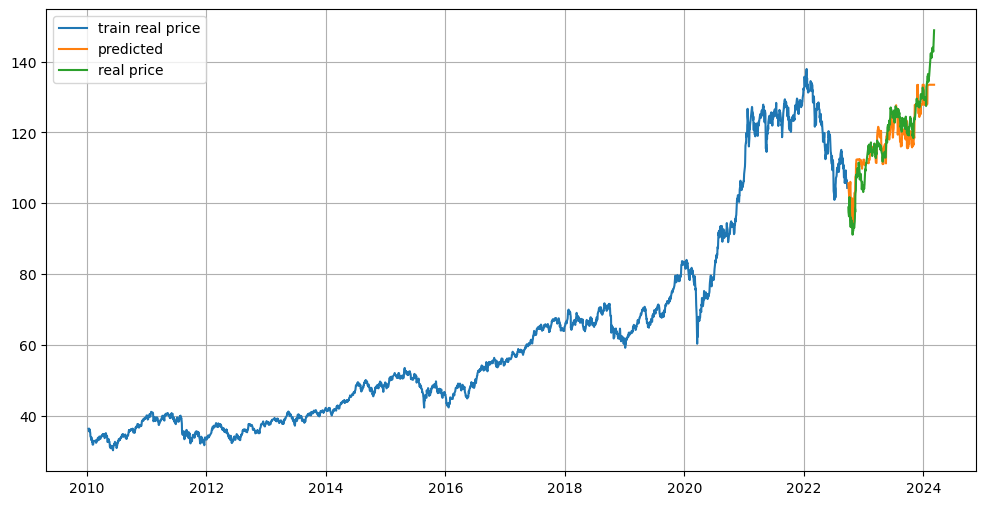

In [1293]:
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(y_price.iloc[sequence_length - 1: train_size].index, y_train.cpu().detach().numpy(), label = 'train real price')
plt.plot(y_price.iloc[train_size + sequence_length - 1: ].index, y_hat[0], label = 'predicted')
plt.plot(y_price.iloc[train_size + sequence_length - 1: ].index, y_test.cpu().detach().numpy(), label = 'real price')
plt.legend()

## 4. LSTM Price Prediction Model for the Next Five Days with Extra Data

In [95]:
past_n_days = 20
sequence_length = 5
seed_value = 0

y_price = stock_data['收盤價(元)']
y_price = y_price.iloc[past_n_days + sequence_length: ]
y_price

年月日
2010-02-06     32.0711
2010-02-08     31.8518
2010-02-09     32.2903
2010-02-10     32.6348
2010-02-22     32.9480
                ...   
2024-02-29    143.3000
2024-03-01    142.8000
2024-03-04    146.9500
2024-03-05    148.1500
2024-03-06    148.8500
Name: 收盤價(元), Length: 3453, dtype: float64

In [96]:
price_feature = pd.DataFrame()
companies = ['台積電', '聯發科', '鴻海', '富邦金', '緯創']#, '廣達', '台達電', '聯電', '中信金', '富邦金', '中華電', '兆豐金', '國泰金', '玉山金', '統一', '聯詠', '緯創', '華碩', '元大金']
for comp in companies:
    company = company_data.filter(like = comp)
    company.columns = company.iloc[0]
    company = company.iloc[1:]
    company = company.set_index(stock_data.index)
    company['收盤價(元)'] = company['收盤價(元)'].astype(float)
    
    price_feature[comp + '_price'] = company['收盤價(元)']
    price_feature[comp + '_rsvol'] = RS_vol(company)
    price_feature[comp + '_法人成交比重'] = company['法人成交比重'] / company['法人成交比重'].rolling(past_n_days).mean()
    price_feature[comp + '_信用交易比重'] = company['信用交易比重'] / company['信用交易比重'].rolling(past_n_days).mean()
    price_feature[comp + '_券資比'] = company['券資比'] / company['券資比'].rolling(past_n_days).mean()
    

price_feature['買賣權未平倉量比率%'] = option_data['買賣權未平倉量比率%']
price_feature['REAINTRATREARAT10Y'] = merged_data_final['REAINTRATREARAT10Y']
price_feature['0050 RS_vol'] = RS_vol(merged_data_final)
price_feature['0050_price'] = merged_data_final['收盤價(元)']

price_feature = price_feature.fillna(method = 'ffill')
price_feature = price_feature.iloc[past_n_days: ]

# 這些資料是當天交易結束會得到的 features，例如 2010/01/04 交易結束會得到的。若要拿來當 features 則需要 shift(1)，預測 2010/01/05 的 returns
display(price_feature)

,台積電_price,台積電_rsvol,台積電_法人成交比重,台積電_信用交易比重,台積電_券資比,聯發科_price,聯發科_rsvol,聯發科_法人成交比重,聯發科_信用交易比重,聯發科_券資比,...,富邦金_券資比,緯創_price,緯創_rsvol,緯創_法人成交比重,緯創_信用交易比重,緯創_券資比,買賣權未平倉量比率%,REAINTRATREARAT10Y,0050 RS_vol,0050_price
年月日,,,,,,,,,,,,,,,,,,,,,
2010-02-01,38.0373,0.000100,1.115105,1.469209,0.514917,250.4851,0.000000,0.833393,1.522790,0.515529,...,0.925323,18.6706,0.000306,1.234587,0.891989,0.843145,73.53,1.297925,0.000211,32.8227
2010-02-02,37.5284,0.000078,1.085112,1.025485,0.488031,247.0130,0.000239,0.946561,1.421339,0.568137,...,0.975561,18.9829,0.000411,1.316559,0.818654,0.966608,70.64,1.297925,0.000125,32.4782
2010-02-03,38.0373,0.000411,0.989692,2.175899,0.471795,252.4691,0.000251,1.153167,1.340809,0.579649,...,0.923294,19.5136,0.000207,0.965123,1.498493,0.986859,70.74,1.297925,0.000025,33.0420
2010-02-04,37.5920,0.000028,1.089772,1.071019,0.456246,255.4452,0.000092,1.318951,0.871530,0.603224,...,0.859287,19.2639,0.000241,1.029492,0.600342,0.976890,71.52,1.297925,0.000040,32.9167
2010-02-05,36.3835,0.000063,0.756027,0.860338,0.496770,253.4611,0.000217,1.031419,1.213940,0.584140,...,0.942627,18.1086,0.000588,0.763279,0.618829,0.904006,59.03,1.297925,0.000083,31.7892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,690.0000,0.000129,1.202036,0.412371,0.773889,1140.0000,0.000236,1.224292,0.516129,2.520194,...,1.168356,115.5000,0.000274,1.620983,0.939597,0.772784,127.09,1.680871,0.000039,143.3000
2024-03-01,689.0000,0.000019,0.851012,0.408163,0.773943,1105.0000,0.000563,1.020196,0.641026,2.174432,...,1.215371,118.0000,0.000232,1.163643,1.020408,0.818174,127.77,1.618134,0.000022,142.8000
2024-03-04,725.0000,0.000082,0.751432,0.600000,1.186944,1150.0000,0.000513,1.008076,0.645161,2.324310,...,1.191031,116.5000,0.000611,1.104660,0.816327,0.845849,145.85,1.618134,0.000040,146.9500


In [97]:
train_size = int(0.9 * price_feature.shape[0])
x_train = price_feature.iloc[: train_size].to_numpy(dtype = float)
x_test = price_feature.iloc[train_size + sequence_length: -sequence_length].to_numpy(dtype = float)
y_train = y_price.iloc[: train_size].to_numpy(dtype = float)
y_test = y_price.iloc[train_size + sequence_length: ].to_numpy(dtype = float)

#display(x_train)
#display(y_train)
#display(x_test)
#display(y_test.tail(10))

feature_standard = StandardScaler()
feature_standard.fit(x_train)
x_train = feature_standard.transform(x_train)
x_test = feature_standard.transform(x_test)


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3112, 29) (3112,) (336, 29) (336,)


In [98]:
# 將 features.shape = number of trading days x number of features ---> number of group of data x sequence_length x number of features

x_train = np.lib.stride_tricks.as_strided(x_train, 
                                          shape=(x_train.shape[0] - sequence_length + 1, sequence_length, x_train.shape[1]), 
                                          strides=(x_train.strides[0], x_train.strides[0], x_train.strides[1])) 
x_test = np.lib.stride_tricks.as_strided(x_test, 
                                          shape=(x_test.shape[0] - sequence_length + 1, sequence_length, x_test.shape[1]), 
                                          strides=(x_test.strides[0], x_test.strides[0], x_test.strides[1])) 
y_train = y_train.reshape(-1, 1)
y_train = np.lib.stride_tricks.as_strided(y_train, 
                                          shape=(y_train.shape[0] - sequence_length + 1, sequence_length, y_train.shape[1]), 
                                          strides=(y_train.strides[0], y_train.strides[0], y_train.strides[1]))
y_test = y_test.reshape(-1, 1)
y_test = np.lib.stride_tricks.as_strided(y_test, 
                                          shape=(y_test.shape[0] - sequence_length + 1, sequence_length, y_test.shape[1]), 
                                          strides=(y_test.strides[0], y_test.strides[0], y_test.strides[1]))

x_train = torch.tensor(x_train, dtype = torch.float32).to(device)
y_train = torch.tensor(y_train, dtype = torch.float32).to(device)
x_test = torch.tensor(x_test, dtype = torch.float32).to(device)
y_test = torch.tensor(y_test, dtype = torch.float32).to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([3108, 5, 29]) torch.Size([3108, 5, 1]) torch.Size([332, 5, 29]) torch.Size([332, 5, 1])


In [99]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCH = 100

input_dim = x_train.shape[2]
hidden_dim = 200
output_dim = 5
num_layers = 10
set_seeds(seed_value)

train_loader = DataLoader(dataset = TensorDataset(x_train, y_train), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(x_test, y_test), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model_MSE = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_MSE.parameters(), lr = LEARNING_RATE)
loss_function_1 = nn.MSELoss()

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_MSE, train_loader, device, loss_function_1, optimizer, input_dim, output_dim)
y_hat = testing_lstm_extradata(lstm_model_MSE, test_loader, loss_function_1, input_dim, output_dim)
y_hat = np.array(y_hat)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [100 / 100], Loss: 1.9791408777236938
LSTM testing MSE for the next 1 day: 38.8178
LSTM testing MSE for the next 2 day: 40.2806
LSTM testing MSE for the next 3 day: 41.6502
LSTM testing MSE for the next 4 day: 43.4315
LSTM testing MSE for the next 5 day: 45.078


In [100]:
set_seeds(seed_value)

train_loader = DataLoader(dataset = TensorDataset(x_train, y_train), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(x_test, y_test), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model_Lasso = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_Lasso.parameters(), lr = LEARNING_RATE)
loss_function_2 = nn.L1Loss()

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_Lasso, train_loader, device, loss_function_2, optimizer, input_dim, output_dim)
y_hat = testing_lstm_extradata(lstm_model_Lasso, test_loader, loss_function_2, input_dim, output_dim)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [100 / 100], Loss: 1.0379621982574463
LSTM testing MSE for the next 1 day: 141.2507
LSTM testing MSE for the next 2 day: 145.7062
LSTM testing MSE for the next 3 day: 149.9512
LSTM testing MSE for the next 4 day: 156.9609
LSTM testing MSE for the next 5 day: 157.123


In [209]:
set_seeds(seed_value)

train_loader = DataLoader(dataset = TensorDataset(x_train, y_train), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(x_test, y_test), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model_DILATE = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_DILATE.parameters(), lr = LEARNING_RATE)
BATCH_SIZE = 8
loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_DILATE, train_loader, device, loss_function_1, optimizer, input_dim, output_dim, True)
y_hat = testing_lstm_extradata(lstm_model_DILATE, test_loader, loss_function_1, input_dim, output_dim)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")
 

## 5. LSTM Next Five Days Return Prediction Model with Extra Data

In [270]:
past_n_days = 20

y_returns = np.log(merged_data_final['收盤價(元)'] / merged_data_final['收盤價(元)'].shift(1)).iloc[1 + past_n_days:]
y_returns = y_returns * 100 
y_returns

年月日
2010-02-02   -1.055125
2010-02-03    1.721038
2010-02-04   -0.379935
2010-02-05   -3.485352
2010-02-06    0.882870
                ...   
2024-02-29   -0.034886
2024-03-01   -0.349528
2024-03-04    2.864734
2024-03-05    0.813288
2024-03-06    0.471381
Name: 收盤價(元), Length: 3457, dtype: float64

In [271]:
price_feature = pd.DataFrame()
#companies = ['台積電', '聯發科', '鴻海', '富邦金', '緯創']#, '廣達', '台達電', '聯電', '中信金', '富邦金', '中華電', '兆豐金', '國泰金', '玉山金', '統一', '聯詠', '緯創', '華碩', '元大金']
companies = ['台積電', '聯發科', '鴻海', '富邦金', '緯創', '廣達', '台達電', '聯電', '中信金', '國泰金', '玉山金', '聯詠']
for comp in companies:
    company = company_data.filter(like = comp)
    company.columns = company.iloc[0]
    company = company.iloc[1:]
    company = company.set_index(stock_data.index)
    company['收盤價(元)'] = company['收盤價(元)'].astype(float)
    
    price_feature[comp + '_price'] = np.log(company['收盤價(元)']/company['收盤價(元)'].shift(1)).iloc[1:]
    company = company.iloc[1:]
    price_feature[comp + '_rsvol'] = RS_vol(company)
    price_feature[comp + '_法人成交比重'] = company['法人成交比重'] / company['法人成交比重'].rolling(past_n_days).mean()
    price_feature[comp + '_信用交易比重'] = company['信用交易比重'] / company['信用交易比重'].rolling(past_n_days).mean()
    price_feature[comp + '_券資比'] = company['券資比'] / company['券資比'].rolling(past_n_days).mean()
    

price_feature['買賣權未平倉量比率%'] = option_data['買賣權未平倉量比率%']
price_feature['REAINTRATREARAT10Y'] = merged_data_final['REAINTRATREARAT10Y']
price_feature['0050 RS_vol'] = RS_vol(merged_data_final)
price_feature['0050_price'] = merged_data_final['收盤價(元)']

price_feature = price_feature.fillna(method = 'ffill')
price_feature = price_feature.iloc[past_n_days: -1]

# 這些資料是當天交易結束會得到的 features，例如 2010/01/04 交易結束會得到的。若要拿來當 features 則需要 shift(1)，預測 2010/01/05 的 returns
display(price_feature)

,台積電_price,台積電_rsvol,台積電_法人成交比重,台積電_信用交易比重,台積電_券資比,聯發科_price,聯發科_rsvol,聯發科_法人成交比重,聯發科_信用交易比重,聯發科_券資比,...,玉山金_券資比,聯詠_price,聯詠_rsvol,聯詠_法人成交比重,聯詠_信用交易比重,聯詠_券資比,買賣權未平倉量比率%,REAINTRATREARAT10Y,0050 RS_vol,0050_price
年月日,,,,,,,,,,,,,,,,,,,,,
2010-02-02,-0.013469,0.000078,1.085112,1.025485,0.488031,-0.013958,0.000239,0.946561,1.421339,0.568137,...,0.192354,-0.044207,0.000202,0.685398,0.805621,0.648277,70.64,1.297925,0.000125,32.4782
2010-02-03,0.013469,0.000411,0.989692,2.175899,0.471795,0.021848,0.000251,1.153167,1.340809,0.579649,...,0.282828,0.054960,0.000225,1.125108,1.115917,0.657796,70.74,1.297925,0.000025,33.0420
2010-02-04,-0.011776,0.000028,1.089772,1.071019,0.456246,0.011719,0.000092,1.318951,0.871530,0.603224,...,0.293255,0.015914,0.000340,0.953785,1.232580,0.784440,71.52,1.297925,0.000040,32.9167
2010-02-05,-0.032676,0.000063,0.756027,0.860338,0.496770,-0.007798,0.000217,1.031419,1.213940,0.584140,...,0.373092,-0.054065,0.000695,0.556797,0.967431,0.596704,59.03,1.297925,0.000083,31.7892
2010-02-06,0.013887,0.000078,0.474546,1.214953,0.581550,0.001955,0.000145,0.246526,2.454652,0.642748,...,0.402765,0.000000,0.001327,0.406784,1.391573,0.594476,56.12,1.297925,0.000195,32.0711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27,0.000000,0.000137,1.109489,3.917526,0.889800,0.000000,0.001374,1.046327,1.025641,2.723038,...,0.164948,0.035327,0.000412,0.933319,1.791045,0.662450,117.68,1.680871,0.000055,143.3500
2024-02-29,-0.011528,0.000129,1.202036,0.412371,0.773889,0.022174,0.000236,1.224292,0.516129,2.520194,...,0.210526,-0.006634,0.000386,1.343588,0.875912,0.707843,127.09,1.680871,0.000039,143.3000
2024-03-01,-0.001450,0.000019,0.851012,0.408163,0.773943,-0.031183,0.000563,1.020196,0.641026,2.174432,...,0.261438,-0.003333,0.000736,0.940734,1.746032,0.737541,127.77,1.618134,0.000022,142.8000


In [276]:
train_size = int(0.9 * price_feature.shape[0])
x_train = price_feature.iloc[: train_size - sequence_length].to_numpy(dtype = float)
x_test = price_feature.iloc[train_size: -sequence_length + 1].to_numpy(dtype = float)
y_train = y_returns.iloc[sequence_length: train_size].to_numpy(dtype = float)
y_test = y_returns.iloc[train_size + sequence_length: ].to_numpy(dtype = float)

#display(x_train.head(10))
#display(y_train)

#display(y_test.tail(10))
#display(x_test)

feature_standard = StandardScaler()
feature_standard.fit(x_train)
x_train = feature_standard.transform(x_train)
x_test = feature_standard.transform(x_test)


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3105, 64) (3105,) (342, 64) (342,)


In [277]:
# 將 features.shape = number of trading days x number of features ---> number of group of data x sequence_length x number of features

x_train = np.lib.stride_tricks.as_strided(x_train, 
                                          shape=(x_train.shape[0] - sequence_length + 1, sequence_length, x_train.shape[1]), 
                                          strides=(x_train.strides[0], x_train.strides[0], x_train.strides[1])) 
x_test = np.lib.stride_tricks.as_strided(x_test, 
                                          shape=(x_test.shape[0] - sequence_length + 1, sequence_length, x_test.shape[1]), 
                                          strides=(x_test.strides[0], x_test.strides[0], x_test.strides[1])) 
y_train = y_train.reshape(-1, 1)
y_train = np.lib.stride_tricks.as_strided(y_train, 
                                          shape=(y_train.shape[0] - sequence_length + 1, sequence_length, y_train.shape[1]), 
                                          strides=(y_train.strides[0], y_train.strides[0], y_train.strides[1]))
y_train = y_train.cumsum(axis = 1)

y_test = y_test.reshape(-1, 1)
y_test = np.lib.stride_tricks.as_strided(y_test, 
                                          shape=(y_test.shape[0] - sequence_length + 1, sequence_length, y_test.shape[1]), 
                                          strides=(y_test.strides[0], y_test.strides[0], y_test.strides[1]))
y_test = y_test.cumsum(axis = 1)



x_train = torch.tensor(x_train, dtype = torch.float32).to(device)
y_train = torch.tensor(y_train, dtype = torch.float32).to(device)
x_test = torch.tensor(x_test, dtype = torch.float32).to(device)
y_test = torch.tensor(y_test, dtype = torch.float32).to(device)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([3101, 5, 64]) torch.Size([3101, 5, 1]) torch.Size([338, 5, 64]) torch.Size([338, 5, 1])


In [278]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCH = 200

input_dim = x_train.shape[2]
hidden_dim = 200
output_dim = 5
num_layers = 10

train_loader = DataLoader(dataset = TensorDataset(x_train, y_train), batch_size  = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = TensorDataset(x_test, y_test), batch_size  = BATCH_SIZE, shuffle = False)

lstm_model_mse = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_mse.parameters(), lr = LEARNING_RATE)
loss_function_mse = nn.MSELoss()

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_mse, train_loader, device, loss_function_mse, optimizer, input_dim, output_dim)
y_hat_mse = testing_lstm_extradata(lstm_model_mse, test_loader, loss_function_mse, input_dim, output_dim)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat_mse[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [200 / 200], Loss: 0.24066650867462158
LSTM testing MSE for the next 1 day: 2.8891
LSTM testing MSE for the next 2 day: 7.2151
LSTM testing MSE for the next 3 day: 11.8786
LSTM testing MSE for the next 4 day: 15.8901
LSTM testing MSE for the next 5 day: 19.9961


In [279]:
S0 = stock_data.loc[y_returns.iloc[train_size + sequence_length - 1 : - sequence_length ].index]['收盤價(元)'].to_list()
price_predict = [[] for i in range(output_dim)]
price_real = [[] for i in range(output_dim)]
for i in range(len(S0)):
    S00 = S0[i]
    for j in range(output_dim):
        S1 = stock_data.loc[y_returns.iloc[train_size + sequence_length + i + j:].index[0]]['收盤價(元)']
        S_pred = np.exp(y_hat_mse[j][i] / 100) * S00
        price_predict[j].append(S_pred)
        price_real[j].append(S1)

for i in range(output_dim):
    print(f"LSTM log return prediction to price MSE: {mean_squared_error(price_real[i], price_predict[i])}")

LSTM log return prediction to price MSE: 4.013124498376598
LSTM log return prediction to price MSE: 10.09480249621549
LSTM log return prediction to price MSE: 16.506949450603553
LSTM log return prediction to price MSE: 22.081932690919214
LSTM log return prediction to price MSE: 27.674434928914135


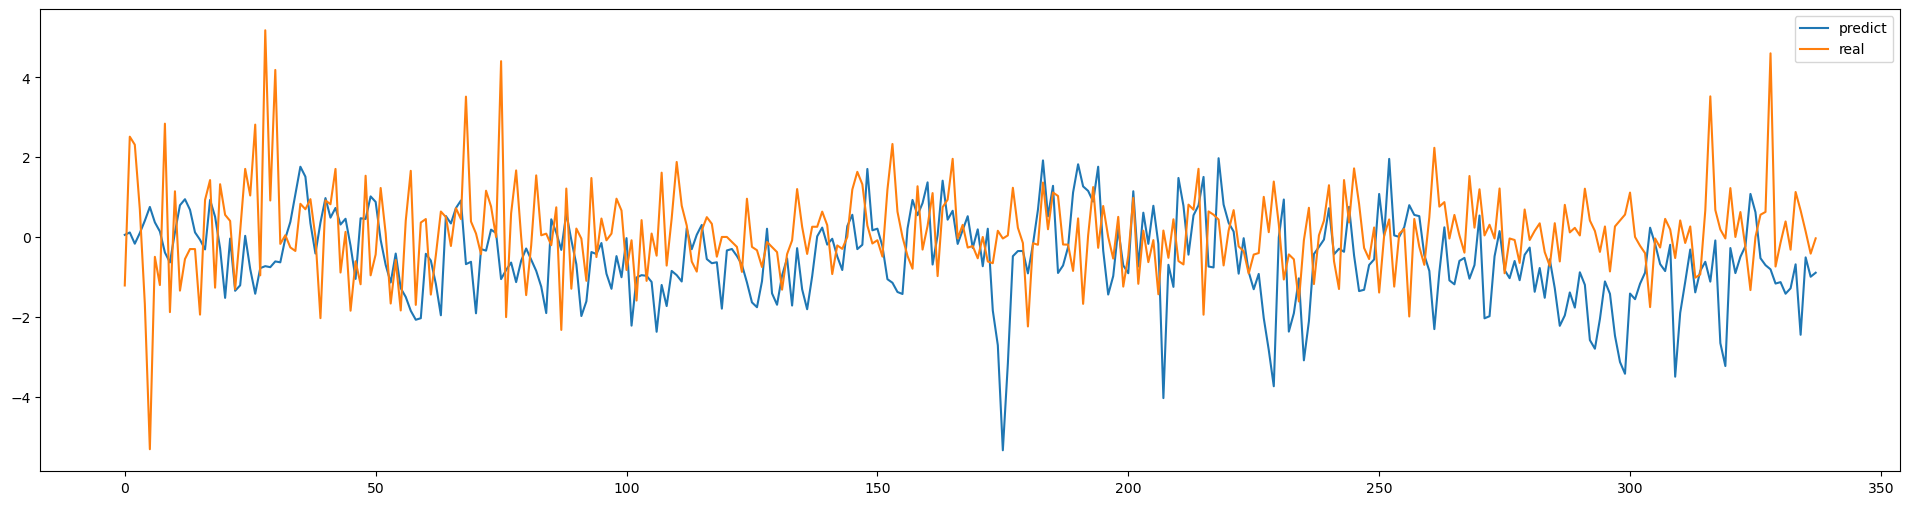

In [280]:
plt.figure(figsize = (24, 6))
plt.plot(y_hat_mse[0], label = 'predict')
plt.plot(y_test_np[:, 0, 0], label = 'real')
plt.legend()

In [281]:
NUM_EPOCH = 200

lstm_model_lasso = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_lasso.parameters(), lr = LEARNING_RATE)
loss_function_lasso = nn.L1Loss()

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_lasso, train_loader, device, loss_function_lasso, optimizer, input_dim, output_dim)
y_hat_lasso = testing_lstm_extradata(lstm_model_lasso, test_loader, loss_function_lasso, input_dim, output_dim)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat_lasso[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [200 / 200], Loss: 0.4044620990753174
LSTM testing MSE for the next 1 day: 2.4499
LSTM testing MSE for the next 2 day: 5.8056
LSTM testing MSE for the next 3 day: 9.3392
LSTM testing MSE for the next 4 day: 12.1248
LSTM testing MSE for the next 5 day: 14.6103


In [282]:
S0 = stock_data.loc[y_returns.iloc[train_size + sequence_length - 1 : - sequence_length ].index]['收盤價(元)'].to_list()
price_predict = [[] for i in range(output_dim)]
price_real = [[] for i in range(output_dim)]
for i in range(len(S0)):
    S00 = S0[i]
    for j in range(output_dim):
        S1 = stock_data.loc[y_returns.iloc[train_size + sequence_length + i + j:].index[0]]['收盤價(元)']
        S_pred = np.exp(y_hat_lasso[j][i] / 100) * S00
        price_predict[j].append(S_pred)
        price_real[j].append(S1)

for i in range(output_dim):
    print(f"LSTM log return prediction to price MSE: {mean_squared_error(price_real[i], price_predict[i])}")

LSTM log return prediction to price MSE: 3.361545694325085
LSTM log return prediction to price MSE: 8.013943985859283
LSTM log return prediction to price MSE: 12.819912723549486
LSTM log return prediction to price MSE: 16.62504330124129
LSTM log return prediction to price MSE: 19.947450497821787


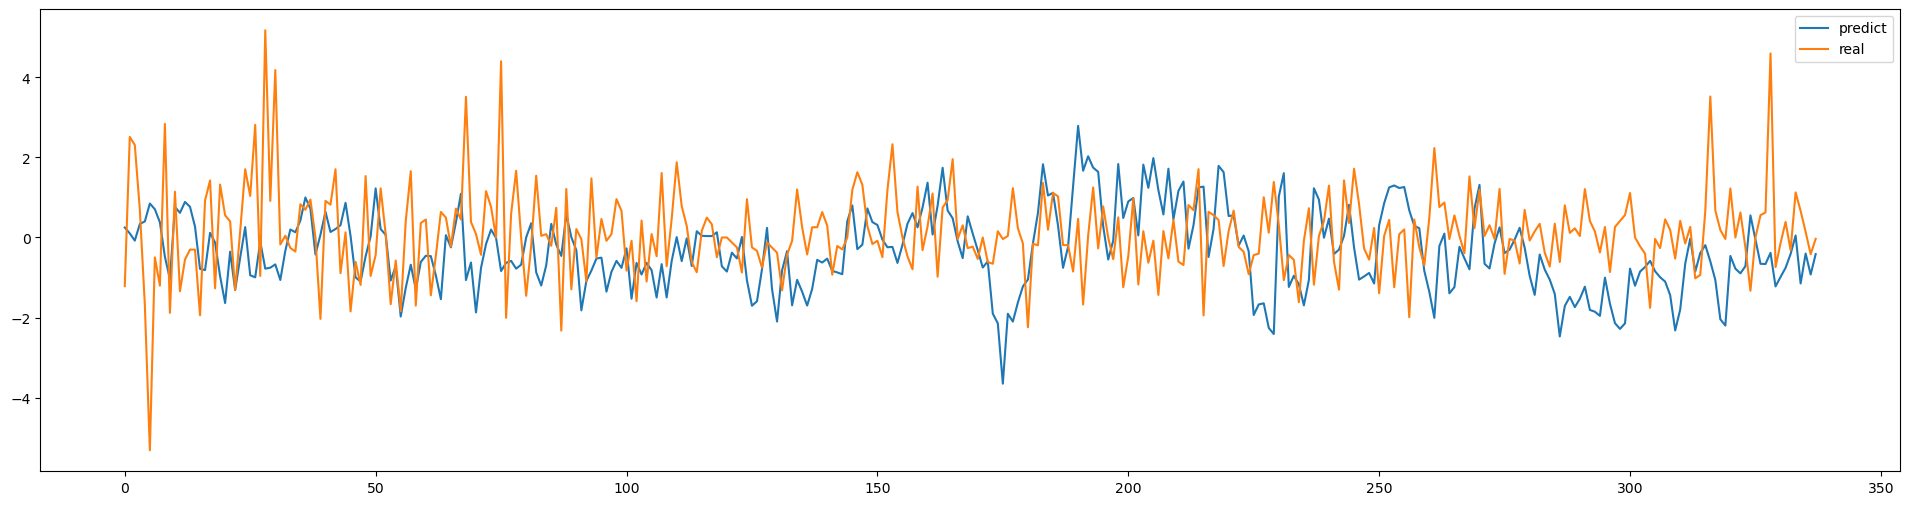

In [283]:
plt.figure(figsize = (24, 6))
plt.plot(y_hat_lasso[0], label = 'predict')
plt.plot(y_test_np[:, 0, 0], label = 'real')
plt.legend()

In [284]:
lstm_model_huber = LSTM(input_dim, hidden_dim, output_dim, num_layers, device).to(device)
optimizer = torch.optim.Adam(lstm_model_huber.parameters(), lr = LEARNING_RATE)
loss_function_huber = nn.HuberLoss()

loss_list = training_lstm_extradata(NUM_EPOCH, lstm_model_huber, train_loader, device, loss_function_huber, optimizer, input_dim, output_dim)
y_hat_huber = testing_lstm_extradata(lstm_model_huber, test_loader, loss_function_huber, input_dim, output_dim)
y_test_np = y_test.cpu().detach().numpy()

for i in range(output_dim):
    MSE = mean_squared_error(y_test_np[:, i, 0], y_hat_huber[i])
    print(f"LSTM testing MSE for the next {i+1} day: {round(MSE, 4)}")

Epoch [200 / 200], Loss: 0.11440469324588776
LSTM testing MSE for the next 1 day: 2.2995
LSTM testing MSE for the next 2 day: 5.5332
LSTM testing MSE for the next 3 day: 9.1949
LSTM testing MSE for the next 4 day: 12.2358
LSTM testing MSE for the next 5 day: 15.4786


In [285]:
S0 = stock_data.loc[y_returns.iloc[train_size + sequence_length - 1 : - sequence_length ].index]['收盤價(元)'].to_list()
price_predict = [[] for i in range(output_dim)]
price_real = [[] for i in range(output_dim)]
for i in range(len(S0)):
    S00 = S0[i]
    for j in range(output_dim):
        S1 = stock_data.loc[y_returns.iloc[train_size + sequence_length + i + j:].index[0]]['收盤價(元)']
        S_pred = np.exp(y_hat_huber[j][i] / 100) * S00
        price_predict[j].append(S_pred)
        price_real[j].append(S1)

for i in range(output_dim):
    print(f"LSTM log return prediction to price MSE: {mean_squared_error(price_real[i], price_predict[i])}")

LSTM log return prediction to price MSE: 3.171017944629658
LSTM log return prediction to price MSE: 7.7015821674028935
LSTM log return prediction to price MSE: 12.693813082788957
LSTM log return prediction to price MSE: 16.89195818330117
LSTM log return prediction to price MSE: 21.26805386823026


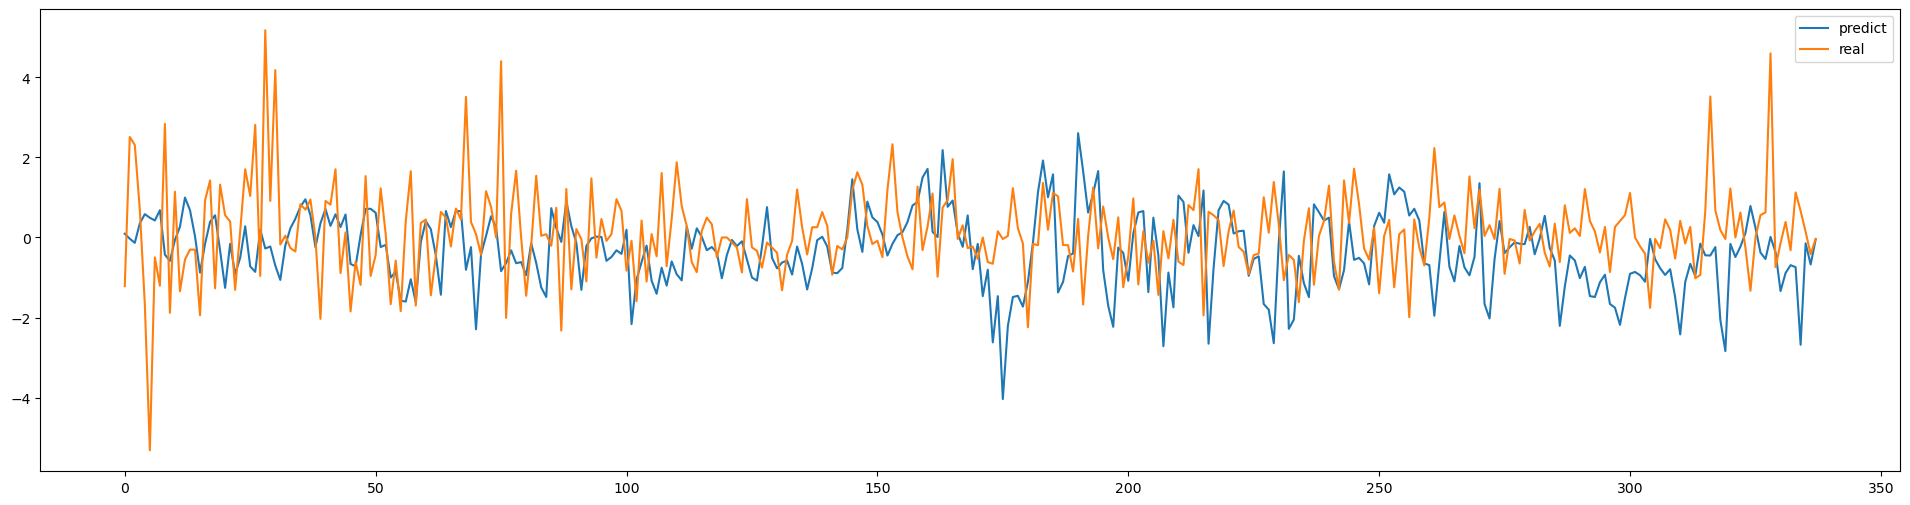

In [286]:
plt.figure(figsize = (24, 6))
plt.plot(y_hat_huber[0], label = 'predict')
plt.plot(y_test_np[:, 0, 0], label = 'real')
plt.legend()